In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score
from xgboost import XGBClassifier

In [2]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/yasserh/titanic-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rehmanzulfiqar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/yasserh/titanic-dataset


In [45]:
df = pd.read_csv('/content/titanic-dataset/Titanic-Dataset.csv')
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
348,349,1,3,"Coutts, Master. William Loch ""William""",male,3.0,1,1,C.A. 37671,15.900,NaN,S
611,612,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.050,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.000,C148,C
767,768,0,3,"Mangan, Miss. Mary",female,30.5,0,0,364850,7.750,NaN,Q
422,423,0,3,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.875,NaN,S


In [4]:
df.shape

(891, 12)

In [5]:
df.drop(columns=['PassengerId','Name'],axis=1,inplace=True)

In [6]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687
Embarked,2


In [7]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
df = df[df['Parch']<=2]

In [14]:
df = df[df['SibSp']<=4]

In [15]:
df = df[df['Ticket'] != 'LINE']

In [16]:
df['ticket_num'] = df['Ticket'].apply(lambda x: x.split()[-1])
df['ticket_num'] = df['ticket_num'].astype(int)

In [17]:
df['ticket_cat'] = df['Ticket'].apply(lambda x: x.split()[0])
df['ticket_cat'] = np.where(df['ticket_cat'].str.isdigit(),np.nan,df['ticket_cat'])

In [18]:
df['ticket_cat']= df['ticket_cat'].fillna('Other')

In [19]:
df.drop('Ticket',axis=1,inplace=True)

In [20]:
df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,170
SibSp,0
Parch,0
Fare,0
Cabin,657
Embarked,2
ticket_num,0


In [21]:
fare_threshold = df['Fare'].quantile(0.97)
fare_threshold
df = df[df['Fare']<=fare_threshold]

In [22]:
df = df[df['Embarked'].notna()]

In [23]:
df['Fare'] = df['Fare'].apply(lambda x : np.round(x,2))

In [24]:
df['Cabin']=df['Cabin'].str.get(0)

In [25]:
df['Cabin'] = df['Cabin'].fillna('Other')

In [26]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,ticket_num,ticket_cat
0,0,3,male,22.0,1,0,7.25,Other,S,21171,A/5
1,1,1,female,38.0,1,0,71.28,C,C,17599,PC
2,1,3,female,26.0,0,0,7.92,Other,S,3101282,STON/O2.
3,1,1,female,35.0,1,0,53.10,C,S,113803,Other
4,0,3,male,35.0,0,0,8.05,Other,S,373450,Other
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.00,Other,S,211536,Other
887,1,1,female,19.0,0,0,30.00,B,S,112053,Other
888,0,3,female,NaN,1,2,23.45,Other,S,6607,W./C.
889,1,1,male,26.0,0,0,30.00,C,C,111369,Other


In [27]:
df['ticket_cat'] = df['ticket_cat'].apply(lambda x : x.replace('.','').replace('/',''))

In [28]:
stono_idx = df[df['ticket_cat']=='SOTONO2'].index
df.loc[stono_idx,['ticket_cat']] = 'STONO2'

In [29]:
uni = df['ticket_cat'].unique()
for i in uni:
    if len(df[df['ticket_cat']==i]) == 1:
        idx = df[df['ticket_cat']==i].index
        df.loc[idx,['ticket_cat']] = 'Other'

var 211.25512377362327
corelation                Age  Survived
Age       1.000000 -0.096806
Survived -0.096806  1.000000


<Axes: ylabel='Age'>

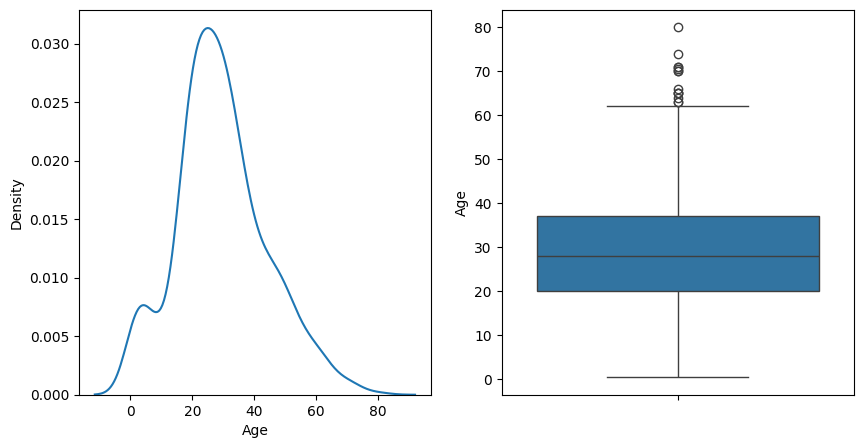

In [ ]:
# before
print('var',df['Age'].var())
print('corelation',df.loc[:,['Age','Survived']].corr())
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.flatten()
sns.kdeplot(df['Age'],ax=axes[0])
sns.boxplot(df['Age'],ax=axes[1])

In [30]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [31]:
df['Age'] = df['Age'].astype(int)

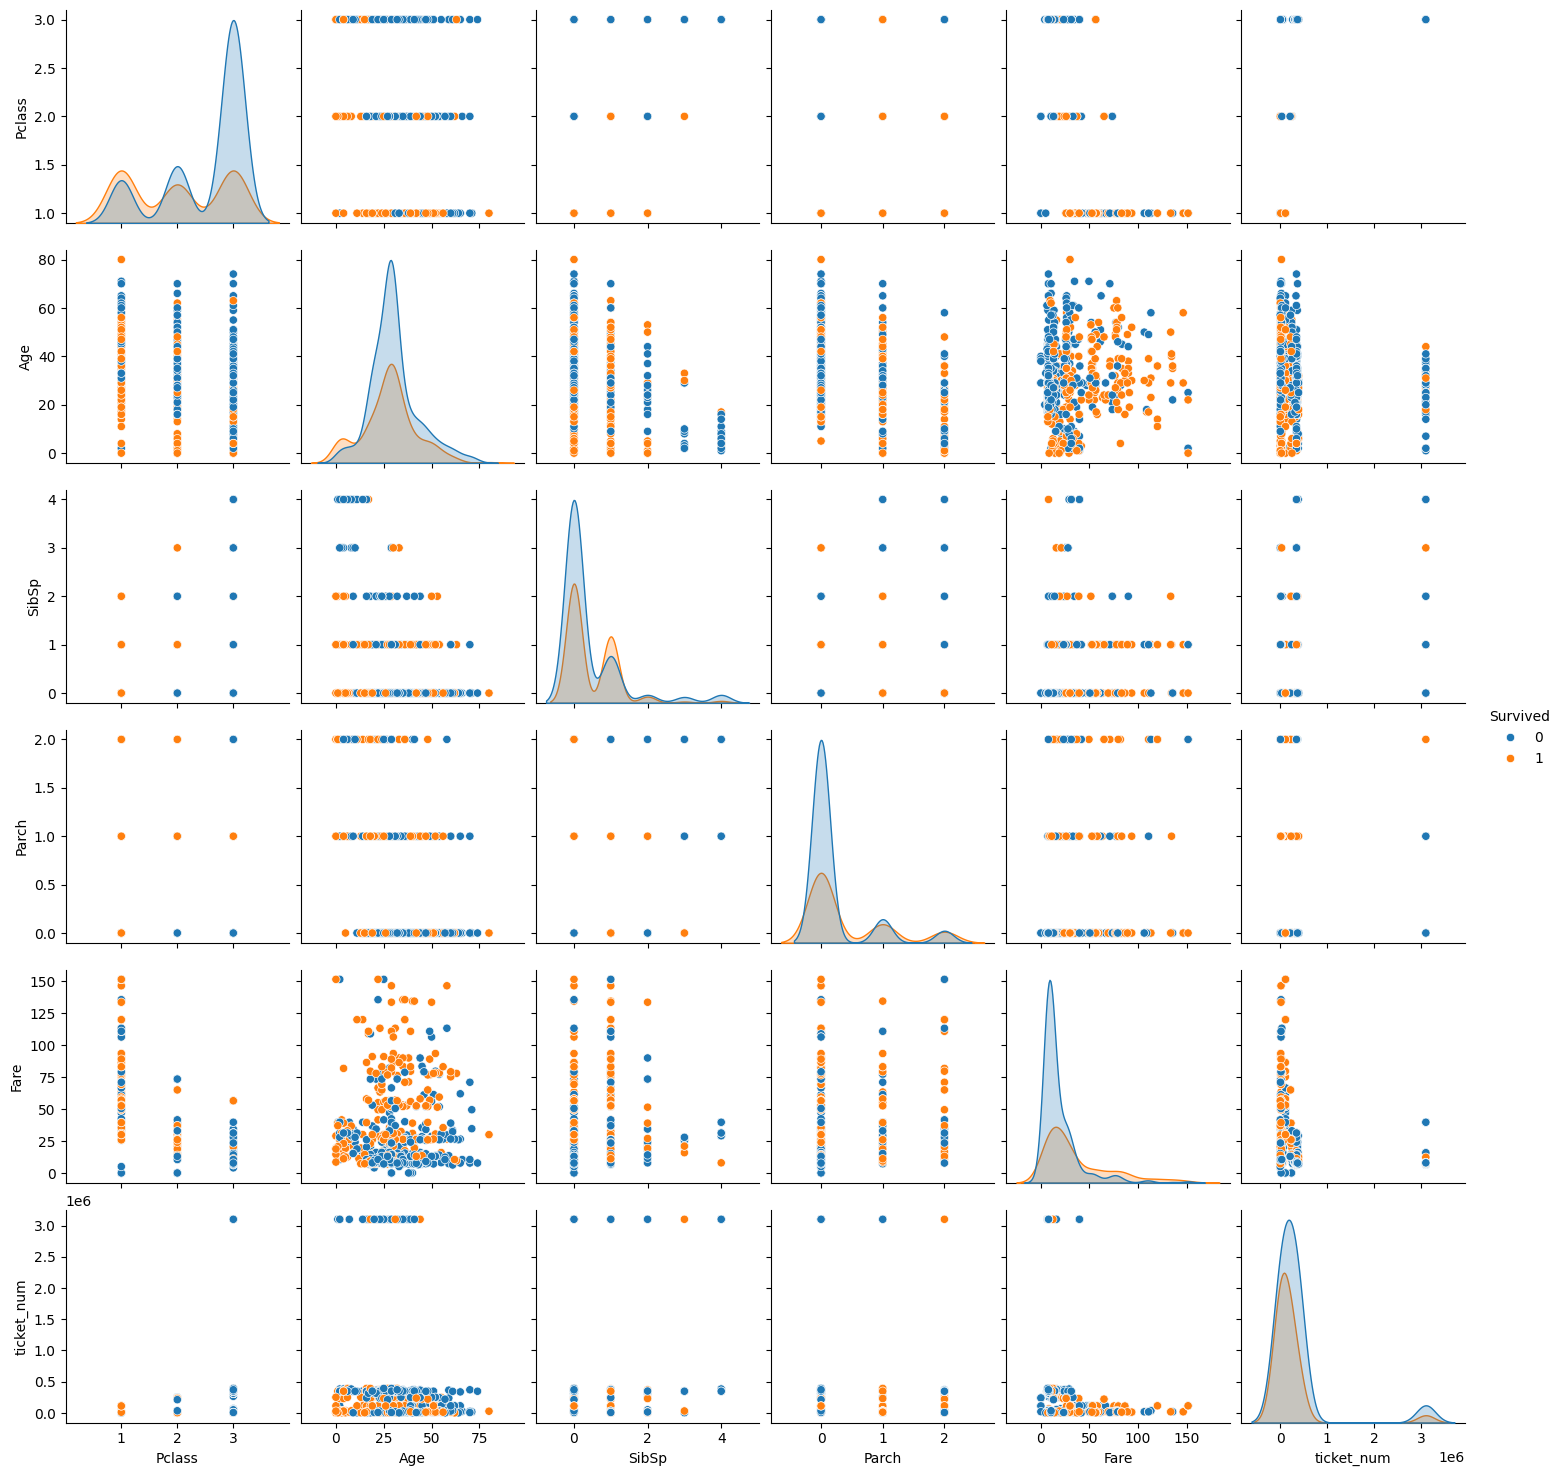

In [ ]:
sns.pairplot(df,hue='Survived')

In [44]:
df.to_csv('titanic_clean.csv',index=None)

In [33]:
X_train,X_test,y_train,y_test = train_test_split(df.drop('Survived',axis=1),df['Survived'],test_size=0.2,random_state=77)

In [34]:
for idx,val in enumerate(X_train.columns):
    print(idx,val)

0 Pclass
1 Sex
2 Age
3 SibSp
4 Parch
5 Fare
6 Cabin
7 Embarked
8 ticket_num
9 ticket_cat


In [35]:
preproces = ColumnTransformer(transformers=[
    ('mode',SimpleImputer(strategy='most_frequent'),[0,3,4]),
    ('ohe',OneHotEncoder(drop='first',sparse_output=False,dtype=np.int32,handle_unknown='ignore'),[1,6,7,9]),
],remainder='passthrough')

In [36]:
model = model = XGBClassifier(n_estimators=120, max_depth=3, learning_rate=0.2)

In [37]:
pipe = Pipeline([
    ('preprocess',preproces),
    ('model',model)
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mode',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [0, 3, 4]),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'numpy.int32'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [1, 6, 7, 9])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=No...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=120, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [38]:
# param = {
#     # 'model__n_estimators':[100,120,140,160],
#     # 'model__max_depth':[3,4,5,6],
#     'model__learning_rate': [0.3,0.4,0.5],
# }
# grid = GridSearchCV(pipe,param_grid=param,scoring='accuracy',n_jobs=-1,cv=3)
# grid.fit(X_train,y_train)

In [39]:
# grid.best_params_

In [40]:
y_pred = pipe.predict(X_test)
accuracy_score(y_test,y_pred)

0.9161676646706587

In [41]:
cross_val_score(pipe,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1).mean()

np.float64(0.800610027067426)

In [42]:
print('Precision',precision_score(y_test,y_pred))
print('Recall',recall_score(y_test,y_pred))

Precision 0.94
Recall 0.8103448275862069


In [ ]:
import joblib
joblib.dump(pipe,'model.pkl')

['model.pkl']

In [ ]:
# score = []
# for i in range(100):
#     X_train,X_test,y_train,y_test = train_test_split(df.drop('Survived',axis=1),df['Survived'],test_size=0.2,random_state=i)
#     pipe = Pipeline([
#         ('preprocess',preproces),
#         ('model',model)
#     ])
#     pipe.fit(X_train,y_train)
#     score.append(pipe.score(X_test,y_test))
# np.argmax(score)
# np.max(score)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categ